# Training Deep Learning Models.

In this notebook the Dutch Dyslexia Programme (DDP) and ePodium dataset are used to train a deep neural network model.
The model is trained to predict the age and risk of dyslexia.
The input data consists of averaged epochs of the EEG data.

+ In section 1. [Prepare Dataset](#1mt) ...
+ In section 2. [Deep Learning](#2mt) ...

It is recommended to run this notebook with CUDA enabled with a dedicated graphics card to speed-up the training.

#### Import Packages

In [1]:
import numpy as np
import os

import local_paths
from functions import processing, display_helper, data_io

from functions.epodium import Epodium
from functions.ddp import DDP
from functions.train_and_predict import EpodiumSequence, DDPSequence

from models import transformer
from models.dnn import fully_connected_model
from models.hfawaz import cnn, encoder

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras.metrics import Precision, BinaryAccuracy, Recall
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

<br>



---
<a id='1mt'></a>
## 1. Prepare Dataset

This notebook works with both the ePodium and the DDP dataset. Choose which dataset to initialize below.

In [2]:
# Choose between datasets: "epodium" "ddp"
dataset_name = "ddp"

if dataset_name == "epodium":
    dataset = Epodium()    
    epochs_directory = local_paths.ePod_epochs
    event_directory = local_paths.ePod_epochs_events
    
    epod_labels = dataset.create_labels(local_paths.ePod_metadata)
    print(f"The available labels are:\n {list(epod_labels.columns)}")

elif dataset_name == "ddp":
    dataset = DDP()
    epochs_directory = local_paths.DDP_epochs
    event_directory = local_paths.DDP_epochs_events
    
    directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
    ddp_labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)
    print(f"The available labels are:\n {list(ddp_labels.columns)}") 

The available labels are:
 ['filename', 'participant', 'age_group', 'age_days']


#### Split processed epochs* into train and test sequence.


First choose which processed data to use


    *In the context of electroencephalography (EEG), epochs are EEG segments in which an event occurs. In the context of deep learning, epochs are iterations over the entire training dataset. We now use epochs in the deep learning context.

In [3]:
experiment_list = processing.valid_experiments(dataset, event_directory, min_standards=180, min_deviants=80)

if dataset_name == "ddp":
    experiment_list = list(set(experiment_list)-set(dataset.wrong_channels_experiments))
    print(f"{len(dataset.wrong_channels_experiments)} experiments have incorrect channels. "
          f"{len(experiment_list)} experiments remain")

# train / test / validation ratio
r = np.array([0.7, 0.15, 0.15])
experiments_train_val, experiments_test = dataset.split_dataset(experiment_list, (r[0]+r[2])/r.sum())
experiments_train, experiments_val = dataset.split_dataset(experiments_train_val, r[0]/(r[0]+r[2]))

print(f"\nThe dataset is split up into {len(experiments_train)} train, "
      f"{len(experiments_test)} test, and {len(experiments_val)} validation experiments")

Analyzed: 1057 bad: 238
819 experiments have enough epochs for analysis.
109 experiments have incorrect channels. 710 experiments remain

The dataset is split up into 498 train, 105 test, and 107 validation experiments


#### Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

TODO explanation on noise + other variables / difference in train/test/val

In [4]:
if dataset_name == "epodium":
    train_sequence = EpodiumSequence(experiments_train, epod_labels, epochs_directory, n_experiments_batch=4, gaussian_noise=1e-6)
    test_sequence = EpodiumSequence(experiments_test, epod_labels, epochs_directory, n_experiments_batch=4)
    val_sequence = EpodiumSequence(experiments_val, epod_labels, epochs_directory, n_experiments_batch=4)
    
if dataset_name == "ddp":
    train_sequence = DDPSequence(experiments_train, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4, gaussian_noise=1e-6)
    test_sequence = DDPSequence(experiments_test, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4)
    val_sequence = DDPSequence(experiments_val, ddp_labels, epochs_directory, n_experiments_batch=8, n_instances_per_experiment=4)

#### Visualise data instance

During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s.

Loading experiment 21_11
The shape of one data instance is (26, 501)
Beware, the absolute value of the y-axis is meaningless due to the data normalization.


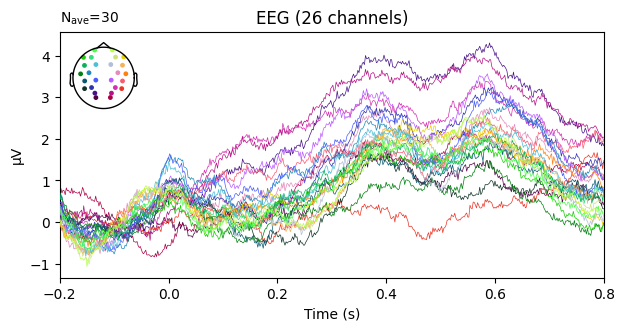

In this experiment the age of the participant is 329 days.


In [5]:
random_participant_index = 0

temp_sequence = DDPSequence(experiments_train, ddp_labels, 
                            epochs_directory, 
                            gaussian_noise=1e-6, 
                            n_trials_averaged=30, 
                            n_experiments_batch=1, 
                            n_instances_per_experiment=1)

x, y = temp_sequence.__getitem__(random_participant_index, True)

print(f"The shape of one data instance is {x[0].shape}")
print("Beware, the absolute value of the y-axis is meaningless due to the data normalization.")
display_helper.plot_array_as_evoked(x[0]*1e-6, dataset.channels_epod_ddp, frequency=500, n_trials=30)
print(f"In this experiment the age of the participant is {int(y[0])} days.")

<br>
<br>

---
<a id='2mt'></a>
## 2. Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.




#### Train model

__input dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ Binary: At risk of dyslexia
+ Regressive: Age, Vocabulary

In [ ]:
model_name = "ddp_encoder_age_26ch_500hz_3"

# Model dimensions
n_channels = 26
n_timesteps = 501
x_dimension = (n_channels, n_timesteps)
y_dimension = 1
model = encoder(x_dimension, y_dimension)

# Hyperparameters
epochs = 100
learning_rate = 1e-3 

# Paths for saving model data
base_dir = os.path.join(local_paths.models, model_name)
model_dir = os.path.join(base_dir, "model")
subsets_dir = os.path.join(base_dir, "subsets")
path_history = os.path.join(base_dir, "history.npy")
path_weights = os.path.join(base_dir, "weights.h5")

if os.path.exists(model_dir):
    print(f"Model: '{model_name}' already exist. Delete the existing model first or rename this model.")    
else:
    print(f"Create model: {model_name}")
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    if not os.path.exists(subsets_dir):
        os.mkdir(subsets_dir)

    # Save train / test / validation sets for future testing
    data_io.save_experiment_names(experiments_train, os.path.join(subsets_dir, "train_set"))
    data_io.save_experiment_names(experiments_test, os.path.join(subsets_dir, "test_set"))
    data_io.save_experiment_names(experiments_val, os.path.join(subsets_dir, "validation_set"))

    # Model configurations
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError()) # , metrics=[Precision(), BinaryAccuracy(), Recall()]
    checkpointer = ModelCheckpoint(filepath=path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1, factor=0.9, verbose=1)
    
    # Fit model
    history = model.fit(x=train_sequence, validation_data=val_sequence, epochs=epochs, callbacks=[checkpointer, reduce_lr])
    
    # Save model and training history
    model.save(model_dir)
    np.save(path_history, history.history)

2022-10-26 09:02:30.459321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 09:02:30.578857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 09:02:30.579146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 09:02:30.580404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Create model: ddp_encoder_age_26ch_500hz_3
Epoch 1/100


2022-10-26 09:02:47.242993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-26 09:02:48.862972: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


63/63 [==============================] - ETA: 0s - loss: 651599.2500
Epoch 1: val_loss improved from inf to 561706.25000, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz_3/weights.h5
63/63 [==============================] - 527s 8s/step - loss: 651599.2500 - val_loss: 561706.2500 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 444379.0938
Epoch 2: val_loss improved from 561706.25000 to 353404.84375, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz_3/weights.h5
63/63 [==============================] - 463s 7s/step - loss: 444379.0938 - val_loss: 353404.8438 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 274895.7500
Epoch 3: val_loss improved from 353404.84375 to 215561.01562, saving model to /home/fpauwels/eegyolk/floris_files/models/trained_models/ddp_encoder_age_26ch_500hz_3/weights.h5
63/63 [=====================

#### Show Training History

In [ ]:
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['loss'], xlabel="epochs", ylabel="validation loss", title=f"Loss during training ({model_name})")
display_helper.show_plot(x=range(len(history.history['loss'])), y=history.history['val_loss'], xlabel="epochs", ylabel="validation loss", title=f"Validation loss during training ({model_name})")